# P&D ISSP - Base notebook
@Students: You are free to edit anything you want.

Packages

In [1]:
import os
import matplotlib
import package.general as genfcns
import package.gui_utils as guifcns
matplotlib.style.use('default')  # <-- for notebooks: white figures background

# Root path (path to where you are storing this very notebook)
ROOTPATH = 'F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main'  #  /!/  Adapt this to your system  /!/ 
pathToSoundFiles = f'{ROOTPATH}/sound_files/'

# Parameters (examples)
speechfilenames = [
    pathToSoundFiles + 'speech1.wav',
    pathToSoundFiles + 'speech2.wav'
]
noisefilenames = [
    pathToSoundFiles + 'Babble_noise1.wav'
]
signalDuration = 10     # [s]

Build acoustic scenario and generate RIRs using GUI

In [20]:
# Launch GUI
guifcns.RIRg_GUI(
    exportFolder=f'{os.getcwd()}/rirs',
    outputRIRplot=False,
    distBwMics=10,  # [cm]
    fs=44100,
    t60=0,
    theme='SystemDefault',
)

[INVALID VALUE] Please enter a room dimension larger than 2 metres.
Note that the RIRs are sampled at 44100 Hz.
PyRoomAcoustics is computing the 5 RIRs...
RIRs computed successfully. Saving as Pickle archive.
RIRs saved in file: "rirs_20250219_143029.pkl.gz", in folder
"f:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main\rirs"
You may close the GUI if not needed anymore!


Acoustic scenario object containing the RIRs, with parameters:
>> Field "audioCoords": [[np.float64(4.95), np.float64(1.9500000000000002)]]
>> Field "audioIds": ['64']
>> Field "c": 340
>> Field "distBwMics": 0.05
>> Field "exportFolder": f:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main/rirs
>> Field "fs": 44100
>> Field "lineIds": [1, 3, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57]
>> Field "lineTextIds": [2, 5, 7, 9, 11, 13, 15, 17, 19, 21, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58]
>> Field "micCoords": [[np.float64(9.05), np.float64(6.0)], [np.float64(9.05), np.float64(6.05)], [np.float64(9.05), np.float64(6.1)], [np.float64(9.05), np.float64(6.15)], [np.float64(9.05), np.float64(6.2)]]
>> Field "micsIds": ['59', '60', '61', '62', '63']
>> Field "nMicsPerArray": 5
>> Field "noiseCoords": []
>> Field "noiseIds": []
>> Field "numMics": 5
>> Field "rirLength": 22050
>> Field "roomDim":

RIRs selection

(22050, 5, 1)


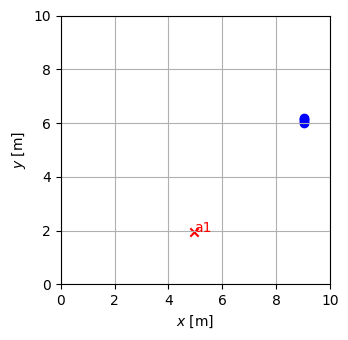

<Figure size 640x480 with 0 Axes>

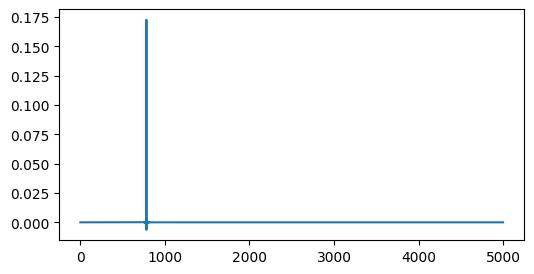

In [21]:
import matplotlib.pyplot as plt
# Select RIRs to be used
# rirFile = 'rirs/'  # use this to input a specific set of RIRs (full path to .pkl.gz file)
rirFile = genfcns.select_latest_rir(path='./rirs/')  # use this to select the lastly generated RIRs
# Load from Pickle archive
acousticScenario = guifcns.load_rirs(path=rirFile)
# >>> NB: the RIRs can be accessed as acousticScenario.RIRsAudio /or/ RIRsNoise
acousticScenario.plot_asc()  # show the acoustic scenario as a pl

plt.figure()
plt.figure(figsize=(6, 3))
plt.plot(acousticScenario.RIRsAudio[0:5000,0,0])

# plt.figure()
# plt.figure(figsize=(6, 3))
# plt.plot(acousticScenario.RIRsNoise[:,0,0])
print(acousticScenario.RIRsAudio.shape)
# print(acousticScenario)

# print(acousticScenario.RIRsAudio)
# print(acousticScenario.RIRsNoise.shape)
# print(acousticScenario)


(441000, 5)


<Figure size 640x480 with 0 Axes>

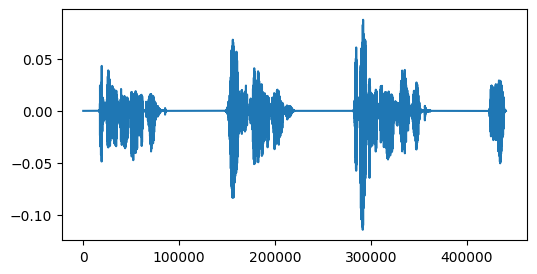

<Figure size 640x480 with 0 Axes>

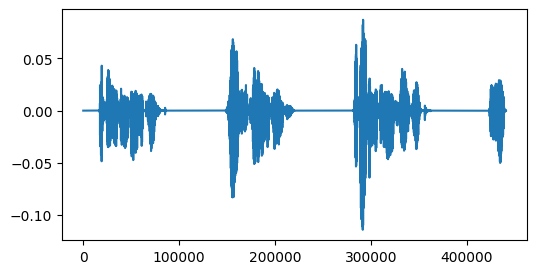

In [22]:
# Part 2
import scipy
import numpy as np
import soundfile as sf
import scipy.signal as signal
import sounddevice as sd

def create_micsigs(audio_name1, audio_name2, noise_name, acousticScenario):
    num_micro = acousticScenario.RIRsAudio.shape[1]   # number of microphones
    num_audio = acousticScenario.RIRsAudio.shape[2]   # number of audio sources
    if acousticScenario.RIRsNoise is None:
        num_noise = 0   # number of noise sources
    else:
        num_noise = acousticScenario.RIRsNoise.shape[2]   # number of noise sources
        RIR_noise1 = acousticScenario.RIRsNoise.squeeze(axis=2)  
      
    fs = acousticScenario.fs    # unit: Hz
    T_ds = int(10*fs)  # unit: s

    if num_audio == 2:
        RIR_audio1, RIR_audio2 = np.dsplit(acousticScenario.RIRsAudio, 2)
        RIR_audio1 = RIR_audio1.squeeze(axis=2)
        RIR_audio2 = RIR_audio2.squeeze(axis=2)
    else:
        RIR_audio1 = acousticScenario.RIRsAudio.squeeze(axis=2)
    
    speech1, sr_speech1 = sf.read(audio_name1)
    speech2, sr_speech2 = sf.read(audio_name2)
    noise1, sr_noise1 = sf.read(noise_name)

    num_samples_speech1 = int(len(speech1) * fs / sr_speech1)
    num_samples_speech2 = int(len(speech2) * fs / sr_speech2)
    num_samples_noise = int(len(noise1) * fs / sr_noise1)
    speech1 = signal.resample(speech1, num_samples_speech1)
    speech2 = signal.resample(speech2, num_samples_speech2)
    noise1 = signal.resample(noise1, num_samples_noise)

    speech1 = speech1[0:T_ds]
    speech2 = speech2[0:T_ds]
    noise1 = noise1[0:T_ds]

    mic1 = []
    mic2 = []

    for i in range(num_micro):
        rec_signal1_tmp = scipy.signal.fftconvolve(speech1, RIR_audio1[:,i])
        if num_audio == 2:
            rec_signal2_tmp = scipy.signal.fftconvolve(speech2, RIR_audio2[:,i])
        else:
            rec_signal2_tmp = np.zeros(rec_signal1_tmp.shape)

        if acousticScenario.RIRsNoise is not None:
            rec_noise_tmp = scipy.signal.fftconvolve(noise1, RIR_noise1[:,i])  
            rec_signal1_tmp = rec_signal1_tmp + rec_noise_tmp

        mic1.append(rec_signal1_tmp)
        mic2.append(rec_signal2_tmp)

    mic1 = np.array(mic1)
    mic2 = np.array(mic2)

    mic = mic1 + mic2    
    mic = mic.T

    return mic[0:T_ds,:], speech1, speech2, noise1, fs

mic, speech1, speech2, noise1, fs = create_micsigs('F:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main\sound_files\speech1.wav', 'F:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main\sound_files\speech2.wav',"F:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main\sound_files\Babble_noise1.wav", acousticScenario)

# sd.play(speech1[0:fs*1], fs)
sd.play(mic[:,0], fs)

print(mic.shape)

plt.figure()
plt.figure(figsize=(6, 3))
plt.plot(mic[:,0])

plt.figure()
plt.figure(figsize=(6, 3))
plt.plot(mic[:,1])


In [ ]:
#Part 3
import numpy as np
import scipy.signal as signal

def TDOA_corr(audio1_name, audio2_name, noise_name, acousticScenario):
  rir1 = acousticScenario.RIRsAudio[:,0,0]
  rir2 = acousticScenario.RIRsAudio[:,1,0]

  direct_path_idx1 = np.argmax(np.abs(rir1))
  direct_path_idx2 = np.argmax(np.abs(rir2))

  ground_truth_TDOA = (direct_path_idx1 - direct_path_idx2) / acousticScenario.fs
  print(f"Ground truth TDOA: {ground_truth_TDOA:.6f} seconds")

  mic_signals, _, _, _, _ = create_micsigs(audio1_name, audio2_name, noise_name, acousticScenario)

  mic1 = mic_signals[:, 0] # Signal of the first mic
  mic2 = mic_signals[:, 1] # Signal of the second mic

  cross_corr = signal.correlate(mic1, mic2, mode="full")
  lags = signal.correlation_lags(len(mic1), len(mic2), mode="full")

  estimated_TDOA = lags[np.argmax(cross_corr)] / acousticScenario.fs
  print(f"Estimated TDOA: {estimated_TDOA:.6f} seconds")

  plt.figure(figsize=(8, 4))
  plt.plot(lags / acousticScenario.fs, cross_corr, label="Crosscorrelation")
  plt.stem([ground_truth_TDOA], [np.max(cross_corr)], linefmt="r-", markerfmt="ro", basefmt="r-", label="Groundtruth")
  plt.stem([estimated_TDOA], [np.max(cross_corr)], linefmt="g-", markerfmt="go", basefmt="g-", label="Estimated value")

  plt.xlabel("Time difference (seconden)")
  plt.ylabel("Crosscorrelation amplitude")
  plt.legend()
  plt.title("TDOA estimate via crosscorrelation")
  plt.xlim(-0.01, 0.01)
  plt.grid()
  plt.show()

  # Step 5: Print de fout tussen de schatting en de grondwaarheid
  error = np.abs(estimated_TDOA - ground_truth_TDOA)
  print(f"TDOA estimation error: {error:.6f} seconds")

TDOA_corr('F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\whitenoise_signal_1.wav', 'F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\whitenoise_signal_2.wav',"F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\Babble_noise1.wav", acousticScenario)



In [ ]:
#Part 4
def DOA_corr(audio1_name, audio2_name, noise_name, acousticScenario):
  mic_signals, _, _, _, _ = create_micsigs(audio1_name, audio2_name, noise_name, acousticScenario)

  mic1 = mic_signals[:,0] # First mic signal
  mic2 = mic_signals[:,1] # Second mic signal

  cross_corr = signal.correlate(mic1, mic2, mode="full")
  lags = signal.correlation_lags(len(mic1), len(mic2), mode="full")

  cross_corr /= np.max(np.abs(cross_corr))
  peaks, properties = signal.find_peaks(cross_corr, height=0.2) # Peaks above 50% of max

  if len(peaks) < 2:
    raise ValueError("Less than 2 peaks found. Cannot estimate exactly 2 DOAs.")
  
  peak_indices = np.argsort(properties["peak_heights"])[-2:] # Get indices of top 2 peaks
  selected_peaks = peaks[peak_indices]

  TDOAestAll = []

  for peak in selected_peaks:
    estimated_TDOA = lags[peak] / acousticScenario.fs
    TDOAestAll.append(estimated_TDOA)

  print(f"First estimated TDOA: {TDOAestAll[0]:.6f} seconds")
  print(f"Second estimated TDOA: {TDOAestAll[1]:.6f} seconds")

  c = 340 # Speed of sound in air (m/s)
  mic_distance = acousticScenario.distBwMics
  TDOAestAll = np.array(TDOAestAll)
  cos_theta = (TDOAestAll * c) / mic_distance # estimated cosine of the angle
  cos_theta = np.clip(cos_theta, -1, 1)
  DOA_estimate = np.arccos(cos_theta) * (180 / np.pi) # Angle in degrees

  print(f"estimated DOA: {DOA_estimate[0]:.2f} degrees")
  print(f"estimated DOA: {DOA_estimate[1]:.2f} degrees")
  
  plt.figure(figsize=(8, 4))
  plt.plot(lags / fs, cross_corr, label="cross correlation")
  plt.axvline(x=estimated_TDOA, color='g', linestyle="--", label=f"TDOA: {estimated_TDOA:.6f}s")

  plt.xlabel("Time difference (seconds)")
  plt.ylabel("Cross correlation amplitude")
  plt.legend()
  plt.xlim(-0.01,0.01)
  plt.title("TDOA and DOA estimation via crosscorrelation")
  plt.grid()
  plt.show()
  

  DOAestAll = DOA_estimate
  DOAestAll = np.array(DOAestAll)
  return DOAestAll

DOAestALL = DOA_corr("F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\whitenoise_signal_1.wav", "F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\whitenoise_signal_2.wav", "F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\Babble_noise1.wav", acousticScenario)
print(DOAestALL)


In [ ]:
# Part 5
def TDOA_corr_2(audio1_name, audio2_name, noise_name, acousticScenario, mic):
 first_source = 0
 second_source = 1
 rir1_1 = acousticScenario.RIRsAudio[:,first_source,0]
 rir2_1 = acousticScenario.RIRsAudio[:,second_source,0]

 direct_path_idx1_1 = np.argmax(np.abs(rir1_1))
 direct_path_idx2_1 = np.argmax(np.abs(rir2_1))

 ground_truth_TDOA_1 = (direct_path_idx1_1 - direct_path_idx2_1) / acousticScenario.fs

 print(f"Ground truth TDOA of source 1: {ground_truth_TDOA_1:.6f} seconds")

 rir1_2 = acousticScenario.RIRsAudio[:,first_source,1]
 rir2_2 = acousticScenario.RIRsAudio[:,second_source,1]

 direct_path_idx1_2 = np.argmax(np.abs(rir1_2))
 direct_path_idx2_2 = np.argmax(np.abs(rir2_2))

 ground_truth_TDOA_2 = (direct_path_idx1_2 - direct_path_idx2_2) / acousticScenario.fs

 print(f"Ground truth TDOA of source 2: {ground_truth_TDOA_2:.6f} seconds")

 mic_signals, _, _, _, _ = create_micsigs(audio1_name, audio2_name, noise_name, acousticScenario)

 mic1 = mic_signals[:, 0] # Signal of the first mic
 mic2 = mic_signals[:, 1] # Signal of the second mic

 cross_corr = signal.correlate(mic1, mic2, mode="full")
 lags = signal.correlation_lags(len(mic1), len(mic2), mode="full")

 cross_corr /= np.max(np.abs(cross_corr))
 peaks, properties = signal.find_peaks(cross_corr, height=0.2) # Peaks above 50% of max

 if len(peaks) < 2:
  raise ValueError("Less than 2 peaks found. Cannot estimate exactly 2 DOAs.")

 # Select the two highest peaks
 peak_indices = np.argsort(properties["peak_heights"])[-2:] # Get indices of top 2 peaks
 selected_peaks = peaks[peak_indices]

 TDOAestAll = []

 for peak in selected_peaks:
    estimated_TDOA = lags[peak] / acousticScenario.fs
    TDOAestAll.append(estimated_TDOA)

 estimated_TDOA = lags[np.argmax(cross_corr)] / acousticScenario.fs

 print(f"First estimated TDOA: {TDOAestAll[1]:.6f} seconds")
 print(f"Second estimated TDOA: {TDOAestAll[0]:.6f} seconds")

 c = 340 # Speed of sound in air (m/s)
 mic_distance = acousticScenario.distBwMics
 TDOAestAll = np.array(TDOAestAll)
 cos_theta = (TDOAestAll * c) / mic_distance # estimated cosine of the angle
 cos_theta = np.clip(cos_theta, -1, 1)
 DOA_estimate = np.arccos(cos_theta) * (180 / np.pi) # Angle in degrees

 print(f"estimated DOA: {DOA_estimate[1]:.2f} degrees")
 print(f"estimated DOA: {DOA_estimate[0]:.2f} degrees")

TDOA_corr_2("F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\whitenoise_signal_1.wav", "F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\whitenoise_signal_2.wav", "F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\Babble_noise1.wav", acousticScenario, mic)


In [ ]:
# Part 6
import numpy as np
import soundfile as sf
import scipy.signal as sig
import matplotlib.pyplot as plt
import os
import glob

def create_micsigs_2(rir_files, audio_file):
  # """Generates microphone signals from measured impulse responses."""
  rir_signals = [sf.read(f)[0] for f in rir_files]
  audio, fs_audio = sf.read(audio_file)

  # Ensure sampling rates match
  fs_rir = sf.read(rir_files[0])[1]

  T_ds = int(3*fs_rir)
  audio = audio[0:T_ds]

  if fs_audio != fs_rir:
    audio = sig.resample(audio, int(len(audio) * fs_rir / fs_audio))

  # Convolve with impulse response
  mic_signals = [sig.fftconvolve(audio, rir)[:len(audio)] for rir in rir_signals]

  return np.column_stack(mic_signals), fs_rir

def estimate_tdoa(mic1, mic2, fs):
  """Estimates the time difference of arrival (TDOA) using cross-correlation."""
  # corr = sig.correlate(mic1, mic2, mode='full')
  # delay = sig.correlation_lags(len(mic1),len(mic2), mode='full')
  # tdoa = delay[np.argmax(corr)] / fs
  corr = sig.correlate(mic1, mic2, mode='full')
  delay = np.argmax(corr) - (len(mic1) - 1)
  tdoa = delay / fs

  plt.figure()
  plt.plot(corr)
  plt.title(f"Cross-Correlation (Delay={delay} samples, TDOA={tdoa:.6f} s)")
  plt.show()

  return tdoa

def estimate_doa(tdoa, mic_spacing, c=340):
  """Converts TDOA into a DOA estimate."""
  # theta = np.arccos((tdoa * c) / mic_spacing) * (180 / np.pi)
  cos_theta = (tdoa * c) / mic_spacing
  cos_theta = np.clip(cos_theta, -1, 1)
  theta = np.arccos(cos_theta)*(180/np.pi)
  return theta

# Paths to impulse responses and target audio
rir_path = "F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\head_mounted_rirs\s30"
audio_file = "F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\part1_track1_dry.wav"
mic_pairs = [("HMIR_L1.wav", "HMIR_L2.wav"), ("HMIR_R1.wav", "HMIR_R2.wav"), ("HMIR_L1.wav", "HMIR_R1.wav")]

# Process each microphone pair
for mic1_file, mic2_file in mic_pairs:
  mic_files = [os.path.join(rir_path, mic1_file), os.path.join(rir_path, mic2_file)]
  mic_signals, fs = create_micsigs_2(mic_files, audio_file)

  # Estimate TDOA
  tdoa = estimate_tdoa(mic_signals[:, 0], mic_signals[:, 1], fs)

  # Define microphone spacing (1.3 cm for same ear, 21.5 cm for opposite ears)
  # mic_spacing = 0.013 if "L1" in mic1_file and "L2" in mic2_file else 0.215
  mic_spacing = 0.215 if "L1" in mic1_file and "R1" in mic2_file else 0.013

  # Estimate DOA
  doa = estimate_doa(tdoa, mic_spacing)
  print(f"DOA estimate for {mic1_file} & {mic2_file}: {doa:.2f}°")



In [ ]:
# RIR_audio1, RIR_audio2 = np.dsplit(acousticScenario.RIRsAudio, 2)
# RIR_audio1 = RIR_audio1.squeeze(axis=2)
# RIR_audio2 = RIR_audio2.squeeze(axis=2)
# RIR1_audio1, RIR2_audio1, RIR3_audio1 = np.hsplit(RIR_audio1, 3)
# RIR1_audio = acousticScenario.RIRsAudio[:,0,0]
# RIR1_audio = RIR_audio1[:,0]
# print(RIR1_audio.shape)

    # rec_speech1 = scipy.signal.fftconvolve(speech1, RIR1_audio1)
    # rec_speech2 = scipy.signal.fftconvolve(speech1, RIR2_audio1)
    # rec_speech3 = scipy.signal.fftconvolve(speech1, RIR3_audio1)

# rec_noise1 = scipy.signal.fftconvolve(noise1, RIR1_noise)
# rec_noise2 = scipy.signal.fftconvolve(noise1, RIR2_noise)
# rec_noise3 = scipy.signal.fftconvolve(noise1, RIR3_noise)

# rec_speech1 = rec_speech1 + rec_noise1[0:len(rec_speech1)]
# rec_speech2 = rec_speech2 + rec_noise2[0:len(rec_speech2)]
# rec_speech3 = rec_speech3 + rec_noise3[0:len(rec_speech3)]

# mic = np.column_stack((rec_speech1, rec_speech2, rec_speech3))

    # RIR_noise1 = np.dsplit(acousticScenario.RIRsNoise, 2)
    # RIR_noise1 = RIR_audio1.squeeze(axis=2)

    # RIR1_audio1, RIR2_audio1, RIR3_audio1 = np.hsplit(RIR_audio1, 3)

    # RIR1_noise = acousticScenario.RIRsNoise[:,0,0]
    # RIR2_noise = acousticScenario.RIRsNoise[:,1,0]
    # RIR3_noise = acousticScenario.RIRsNoise[:,2,0]

    # max_cols = max(mic1.shape[1], mic2.shape[1])
    # mic1_padded = np.pad(mic1, ((0, 0), (0, max_cols - mic1.shape[1])), mode='constant')
    # mic2_padded = np.pad(mic2, ((0, 0), (0, max_cols - mic2.shape[1])), mode='constant')

    # mic = np.vstack((mic1_padded,mic2_padded))
    # mic = mic1_padded + mic2_padded

# rec_signal1_tmp = rec_signal1_tmp + rec_noise_tmp[0:len(rec_signal1_tmp)]  #may have problems if length of noise is shorter than the signals!

  # estimated_TDOA = lags[np.argmax(cross_corr)] / acousticScenario.fs

  # fs = acousticScenario.fs # Sampling frequentie uit RIR GUI
  # estimated_TDOA = lags[np.argmax(cross_corr)] / fs # TDOA in seconds

  # print(f"estimated TDOA: {estimated_TDOA:.6f} seconds")

  # cos_theta = (estimated_TDOA * c) / mic_distance # estimated cosine of the angle

  # DOA_estimate = 90 - DOA_estimate # 90° is broadside, 180° is end-fire

# print(f"estimated DOA: {DOA_estimate[1]:.2f} degrees")

# mic_part6, fs_part6= create_micsigs_2(rir_path, audio_file)

# print(mic_part6.shape)
# sd.play(mic_signals[:,0], fs)

  # if os.path.isdir(rir_path):
  #       rir_files = glob.glob(os.path.join(rir_path, "*.wav"))  # 默认寻找 WAV 文件
  #       if len(rir_files) == 0:
  #           raise ValueError(f"No RIR files found in {rir_path}")
  # else:
  #       rir_files = rir_path  # 如果已经是列表，则直接使用

  # # 读取所有 RIR 文件
  # rir_signals = [sf.read(f)[0] for f in rir_files]

#  rir1_1 = acousticScenario.RIRsAudio[:,0,0]
#  rir2_2 = acousticScenario.RIRsAudio[:,1,0]

#  rir1_2 = acousticScenario.RIRsAudio[:,0,1]
#  rir2_2 = acousticScenario.RIRsAudio[:,1,1]

#  mic1 = mic_signals[:, mic[0]] # Signal of the first mic
#  mic2 = mic_signals[:, mic[1]] # Signal of the second mic



# Signal processing - Week 2: MUSIC algorithm

Computing DOAs via freq.-domain MUSIC algorithm...


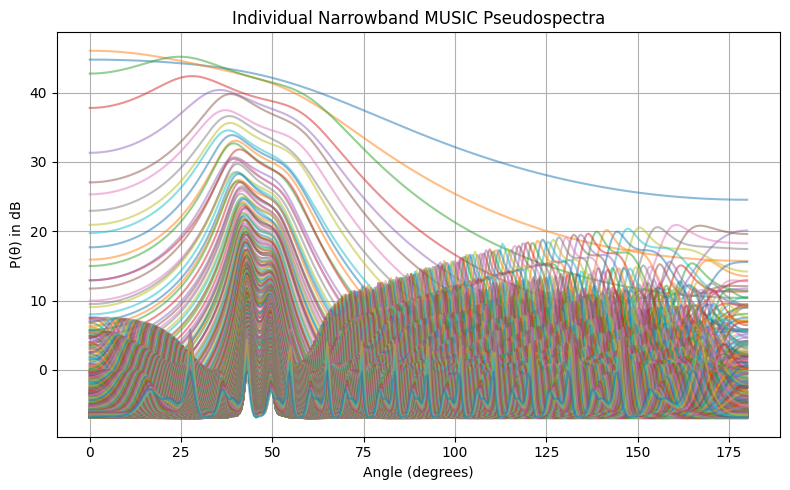

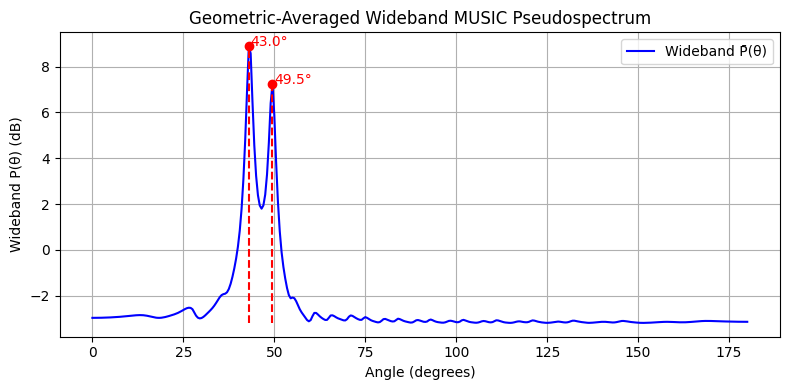

All estimated DOAs: [2836.1410859  2463.71851906]
Selected estimated DOAs: [2463.72 2463.72]
Ground truth DOAs: [42.6  48.98]
Estimate error(s): [ 6.9  -5.98] deg.
[49.5 43. ]


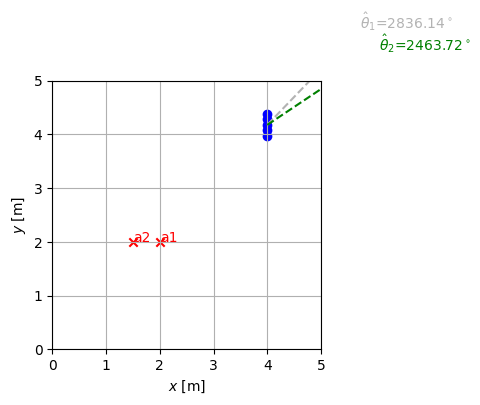

In [12]:
import numpy as np

winLength = 1024 # Window length
# nSources = acousticScenario.RIRsAudio.shape[-1] +\
#     acousticScenario.RIRsNoise.shape[-1] # Number of sources
theta = np.arange(0, np.pi, step=np.pi / 360)  # angles to consider

print('Computing DOAs via freq.-domain MUSIC algorithm...')

# DOAestAll = DOA_corr("F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\whitenoise_signal_1.wav", "F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\whitenoise_signal_2.wav", "F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\Babble_noise1.wav", acousticScenario)
# DOAestAll = music_narrowband(stft_mics, acousticScenario.fs, acousticScenario.RIRsAudio.shape[2], acousticScenario.distBwMics, c=340)
DOAestAll = music_wideband(stft_mics, acousticScenario.fs, acousticScenario.RIRsAudio.shape[2], acousticScenario.distBwMics, c=340)
# DOAestAll = np.zeros(nSources)  # default

print(f'All estimated DOAs: {DOAestAll * 180 / np.pi}')

# ------------------ DOA estimation performance check ------------------
# Automatic selection of the target DOA
DOAest, groundTruthDOAtalkers = genfcns.auto_choice_doa(
    DOAestAll, acousticScenario
)
print(f'Selected estimated DOAs: {np.round(DOAest * 180 / np.pi, 2)}')
print(f'Ground truth DOAs: {np.round(groundTruthDOAtalkers * 180 / np.pi, 2)}')
# Check validity
genfcns.check_plot_tdoas(DOAest, DOAestAll, acousticScenario)
# print(f'Estimate error(s): {np.round((DOAest - groundTruthDOAtalkers) * 180/np.pi, 2)} deg.')
print(f'Estimate error(s): {DOAestAll - np.round(groundTruthDOAtalkers * 180 / np.pi, 2)} deg.')
print(DOAestAll)

In [23]:
#frequency check
if acousticScenario.fs == 44100:
    print("Correct sampling frequency: 44.1 kHz")
else:
    raise ValueError(f"False: Incorrect sampling frequency, current sampling frequency {acousticScenario.fs} Hz")

Correct sampling frequency: 44.1 kHz


In [24]:
import numpy as np
from scipy.signal import stft

# parameters
fs = 44100         # sampling frequency
L = 1024           # window length
hop = L // 2       # 50% overlap
M = mic.shape[1]   # number of microphones
n_samples = mic.shape[0]  # number of samples

stft_mics_list = []

for m in range(M):
    mic_signal = mic[:, m]
    
    f, t, Zxx = stft(mic_signal,
                     fs=fs,
                     window='hann',
                     nperseg=L,
                     noverlap=hop,
                     return_onesided=True)

    # Zxx 形状一般为 (nF, nT)，其中 nF = L/2+1（对真实信号 return_onesided=True 时）
    stft_mics_list.append(Zxx)

stft_mics = np.array(stft_mics_list)  # (M, nF, nT)

print("stft_mics shape:", stft_mics.shape)

stft_mics shape: (5, 513, 863)


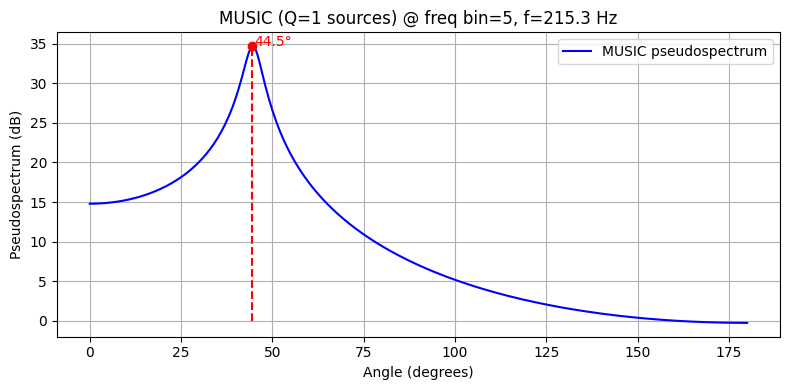

[44.5]


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def music_narrowband(stft_mics, fs, Q, d, c):
    """
    参数:
    --------
    stft_mics : ndarray, shape (M, nF, nT)
        M 个麦克风的 STFT 结果:
          - M: 麦克风数量
          - nF: 频率 bin 个数
          - nT: 时间帧数
    fs : float
        采样率 (Hz)。
    Q : int
        目标声源数量 (已知)。
    d : float
        相邻麦克风阵元间距 (m)。
    c : float
        声速 (m/s)。
        
    返回:
    --------
    doa_estimates : ndarray, shape (Q,)
        估计的 Q 个 DOA (单位: °)，可能无序，可自行排序。
    """
    
    M, nF, nT = stft_mics.shape
    
    # -------------------------------------------------------------------------
    # 1) 找到能量最大的频点（与单源版本相同）
    # -------------------------------------------------------------------------
    power_per_bin = np.mean(np.abs(stft_mics)**2, axis=(0, 2))  # shape = (nF,)
    # 若出现 DC bin 功率过大，可手动置零以避免其干扰
    # power_per_bin[0] = 0  # 避免选到 DC bin
    
    fidx = np.argmax(power_per_bin)  # 最强能量的频点索引
    
    # 也可以使用 stft 返回的真实频率数组 f 来取 f_bin = f[fidx]
    # 这里演示一个近似公式:
    # f_bin = (fidx / (nF - 1)) * (fs / 2)
    f_bin = f[fidx]
    
    # -------------------------------------------------------------------------
    # 2) 提取该频点在所有麦克风、所有时间帧的数据 => 用于计算空间协方差 Rxx
    # -------------------------------------------------------------------------
    X_omega = stft_mics[:, fidx, :]  # shape = (M, nT)
    Rxx = (X_omega @ X_omega.conj().T) / nT  # (M, M)
    
    # -------------------------------------------------------------------------
    # 3) 特征分解，区分 (Q) 信号子空间和 (M - Q) 噪声子空间
    # -------------------------------------------------------------------------
    eigenvals, eigenvecs = np.linalg.eig(Rxx)
    sort_idx = np.argsort(eigenvals)       # 从小到大
    eigenvals_sorted = eigenvals[sort_idx]
    eigenvecs_sorted = eigenvecs[:, sort_idx]
    
    # 噪声子空间对应最小的 (M - Q) 个特征值
    Un = eigenvecs_sorted[:, :M - Q]  # shape (M, M-Q)
    
    # -------------------------------------------------------------------------
    # 4) 遍历角度 θ=0°~180°, 步进 0.5°, 计算 MUSIC 伪谱
    #    P(θ) = 1 / ( a^H(θ)*Un*Un^H*a(θ) )
    # -------------------------------------------------------------------------
    theta_vals = np.arange(0, 180.5, 0.5)
    k0 = 2 * np.pi * f_bin / c  # 波数
    P_music = []
    
    m_index = np.arange(M)  # 对应麦克风索引 0,1,2,...,M-1
    
    for theta_deg in theta_vals:
        theta_rad = np.deg2rad(theta_deg)
        # 若 0° 定义在端火方向(沿阵列)，应使用 cos(θ)
        # 若 0° 定义在broadside(垂直阵列), 则使用 sin(θ)
        # 题目倾向 "0°=top end-fire", 故用 cos(θ):
        steer = np.exp(-1j * k0 * m_index * d * np.cos(theta_rad))  # (M,)
        
        v = Un.conj().T @ steer  # shape = (M-Q,)
        denom = np.abs(v @ v.conj())
        pseudospec = 1.0 / denom
        P_music.append(pseudospec)
        
    P_music = np.array(P_music)  # shape (len(theta_vals),)
    
    # -------------------------------------------------------------------------
    # 5) 在伪谱中寻找 Q 个最大的峰，对应 Q 个声源方位
    # -------------------------------------------------------------------------
    # 简单方式: 直接取 P_music 最大的 Q 个点(可能需要去重/不相邻)
    # peak_indices = np.argsort(P_music)[-Q:]   # 取倒数Q个(最大的Q个)
    # peak_indices = peak_indices[::-1]         # 从大到小
    
    # doa_estimates = theta_vals[peak_indices]  # 角度 (°)，可能乱序
    peaks, _ = find_peaks(P_music, distance=5, prominence=0.1)
    
    if len(peaks) == 0:
        print("Warning: no peak found!")
        doa_estimates = np.array([])
    else:
        # 按幅度取最大的 Q 个
        peak_values_all = P_music[peaks]
        if len(peaks) < Q:
            # 如果实际峰数少于 Q，只能返回所有峰
            topQ_idx = np.argsort(peak_values_all)[::-1]  # 从大到小
        else:
            topQ_idx = np.argsort(peak_values_all)[-Q:]   # 取最大的 Q 个
        # 排序一下(可选)
        topQ_idx_sorted = topQ_idx[np.argsort(peak_values_all[topQ_idx])]  
        
        peak_indices = peaks[topQ_idx_sorted]
        doa_estimates = theta_vals[peak_indices]
    
    # -------------------------------------------------------------------------
    # 6) 可视化：绘制 pseudospectrum，并标记 Q 个峰
    # -------------------------------------------------------------------------
    plt.figure(figsize=(8,4))
    plt.plot(theta_vals, 10*np.log10(P_music), 'b-', label='MUSIC pseudospectrum')
    
    # 在图上标记 Q 个峰
    for i, idx in enumerate(peak_indices):
        peak_angle = theta_vals[idx]
        peak_value = 10*np.log10(P_music[idx])
        plt.stem([peak_angle], [peak_value], linefmt='r--', markerfmt='ro', basefmt=" ")
        plt.text(peak_angle+0.5, peak_value, f"{peak_angle:.1f}°", color='red')
    
    plt.title(f"MUSIC (Q={Q} sources) @ freq bin={fidx}, f={f_bin:.1f} Hz")
    plt.xlabel("Angle (degrees)")
    plt.ylabel("Pseudospectrum (dB)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return doa_estimates

doa_estimates = music_narrowband(stft_mics, acousticScenario.fs, acousticScenario.RIRsAudio.shape[2], acousticScenario.distBwMics, c=340)



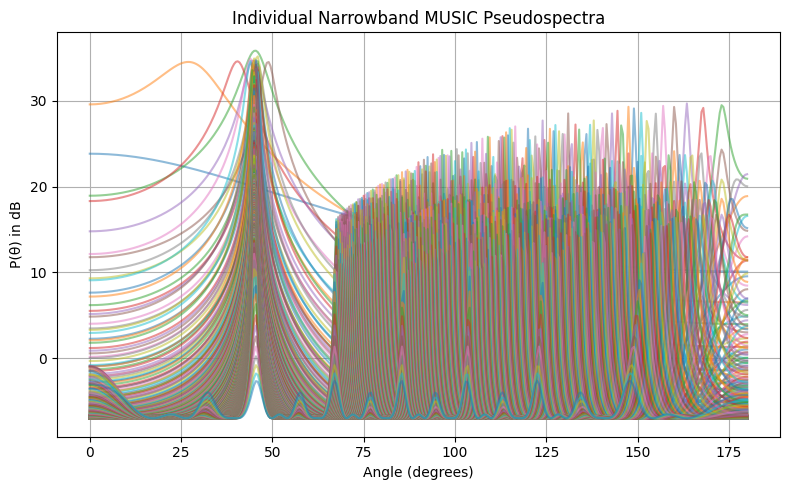

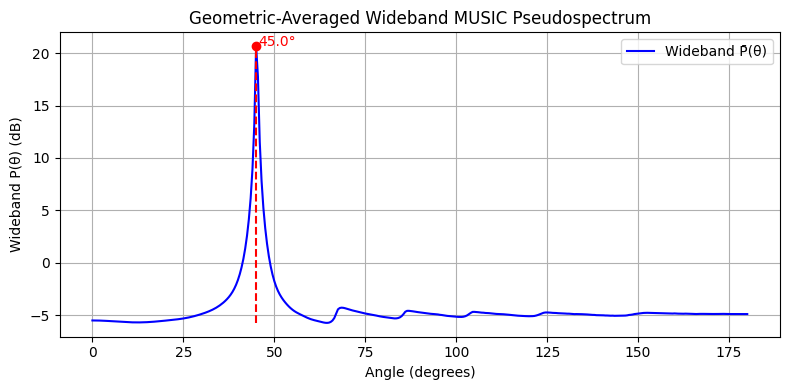

[45.]


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def music_wideband(stft_mics, fs, Q, d, c):
    """    
    参数:
    -----------
    stft_mics : ndarray, shape (M, nF, nT)
        M 个麦克风的 STFT 结果 (单边频谱):
          - M: 麦克风数量
          - nF: 频率 bin 个数 (L/2 + 1 对应 window_size=L)
          - nT: 时间帧数
    fs : float
        采样率(Hz)。
    Q : int
        声源数量。
    d : float
        相邻麦克风之间的阵元间距(m)。
    c : float
        声速(m/s)。
        
    返回:
    -----------
    doa_estimates : ndarray, shape (Q,)
        宽带 MUSIC 估计得到的 Q 个 DOA (角度, 单位: °)。
    """
    M, nF, nT = stft_mics.shape
    
    # -------------------------------------------------------------------------
    # 0) 准备角度搜索表, 例如 0~180°, 步进 0.5°
    # -------------------------------------------------------------------------
    theta_vals = np.arange(0, 180.5, 0.5)
    nTheta = len(theta_vals)
    
    # 为了记录每个频点的单频 MUSIC 伪谱 p_{k}(\theta)，
    # 准备一个二维数组 all_pseudospec，行 = 频点，列 = 角度
    # 注意我们要跳过 DC bin(索引=0) 和 Nyquist bin(索引=nF-1)
    freq_bins = range(1, nF-1)  # 1-based里即 "k=2,...,L/2"
    nFreqUsed = len(freq_bins)
    
    all_pseudospec = np.zeros((nFreqUsed, nTheta), dtype=float)
    
    # -------------------------------------------------------------------------
    # 1) 对每个有效频点 k, 计算窄带 MUSIC 伪谱 p_{k}(\theta)
    # -------------------------------------------------------------------------
    for i, fidx in enumerate(freq_bins):
        # 频率对应的实际 Hz
        # 若保留了 stft(...) 的返回频率数组 f，可直接 f_bin = f[fidx]
        # 这里用线性映射的简化方式:
        # f_bin = (fidx / (nF - 1)) * (fs / 2)
        f_bin = f[fidx]
        
        # 提取该频点在所有麦克风、时间帧的数据 => 空间协方差 Rxx
        X_omega = stft_mics[:, fidx, :]  # (M, nT)
        Rxx = (X_omega @ X_omega.conj().T) / nT
        
        # 特征分解, 取噪声子空间 (M-Q)
        eigenvals, eigenvecs = np.linalg.eig(Rxx)
        sort_idx = np.argsort(eigenvals)
        Un = eigenvecs[:, sort_idx[:(M-Q)]]  # (M, M-Q)
        
        # 逐角度计算窄带 MUSIC 伪谱
        k0 = 2.0 * np.pi * f_bin / c
        m_index = np.arange(M)
        
        for j, theta_deg in enumerate(theta_vals):
            theta_rad = np.deg2rad(theta_deg)
            # 如果题目定义 "0°=端火方向", 用 cos(θ).
            # 若 "0°=broadside", 则改成 sin(θ).
            steer = np.exp(-1j * k0 * m_index * d * np.cos(theta_rad))
            
            v = Un.conj().T @ steer
            denom = np.abs(v @ v.conj())
            pseudospec = 1.0 / denom
            
            all_pseudospec[i, j] = pseudospec
    
    # -------------------------------------------------------------------------
    # 2) 可选：绘制所有单频伪谱 (方便对比)
    # -------------------------------------------------------------------------
    plt.figure(figsize=(8,5))
    for i in range(nFreqUsed):
        plt.plot(theta_vals, 10*np.log10(all_pseudospec[i, :]), alpha=0.5, label=f"bin {freq_bins[i]}")
    plt.title("Individual Narrowband MUSIC Pseudospectra")
    plt.xlabel("Angle (degrees)")
    plt.ylabel("P(θ) in dB")
    plt.grid(True)
    # plt.legend(loc='best', ncol=2, fontsize='small')
    plt.tight_layout()
    plt.show()
    
    # -------------------------------------------------------------------------
    # 3) 计算几何平均的宽带伪谱:
    #       p̄(θ) = [∏ p_k(θ)]^(1 / nFreqUsed)
    #   为避免数值下溢, 用 log 域处理:
    #       log p̄(θ) = (1/nFreqUsed) * Σ(log p_k(θ))
    # -------------------------------------------------------------------------
    log_all = np.log(all_pseudospec + 1e-15)  # 避免 log(0)
    mean_log = np.mean(log_all, axis=0)      # 对频点做平均
    p_wideband = np.exp(mean_log)            # 几何平均
    # p_wideband.shape = (nTheta,)
    
    # -------------------------------------------------------------------------
    # 4) 在宽带伪谱中寻找 Q 个峰, 并可视化
    #    (同多源 MUSIC 的做法, 可以用 find_peaks)
    # -------------------------------------------------------------------------
    # 需要先把 p_wideband 转换成 dB 或保持线性值看你需要
    # 这里先找峰，再绘图
    peaks, properties = find_peaks(
        p_wideband,
        distance=5,     # 至少分开几个采样点(约2.5°)
        prominence=0.1  # 视数据情况调整
    )
    
    if len(peaks) == 0:
        print("警告: 宽带伪谱中未找到任何峰!")
        doa_estimates = np.array([])
    else:
        peak_vals = p_wideband[peaks]
        # 取幅度最大的 Q 个
        if len(peaks) >= Q:
            idx_top = np.argsort(peak_vals)[-Q:]
        else:
            idx_top = np.argsort(peak_vals)  # 所有峰都用上
        # 按大小排序(可选)
        idx_top_sorted = idx_top[np.argsort(peak_vals[idx_top])]
        
        peak_indices = peaks[idx_top_sorted]
        doa_estimates = theta_vals[peak_indices]  # Q个DOA (°)
    
    # -------------------------------------------------------------------------
    # 5) 绘制最终的宽带伪谱 & 标记峰
    # -------------------------------------------------------------------------
    plt.figure(figsize=(8,4))
    plt.plot(theta_vals, 10*np.log10(p_wideband), 'b-', label='Wideband P̄(θ)')
    plt.grid(True)
    plt.xlabel("Angle (degrees)")
    plt.ylabel("Wideband P(θ) (dB)")
    plt.title("Geometric-Averaged Wideband MUSIC Pseudospectrum")
    
    # 标记Q个峰
    for doa in doa_estimates:
        val_db = 10*np.log10(p_wideband[theta_vals==doa])
        plt.plot(doa, val_db, 'ro')
        plt.vlines(doa, min(10*np.log10(p_wideband)), val_db, color='r', linestyles='--')
        plt.text(doa+0.5, val_db, f"{doa:.1f}°", color='red')
    
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return doa_estimates

doa_estimates_wideband = music_wideband(stft_mics, acousticScenario.fs, acousticScenario.RIRsAudio.shape[2], acousticScenario.distBwMics, c=340)

